In [2]:
import perceval as pcvl
import numpy as np
import itertools
from Simulation import create_inputs, calculate_proba
from Functions import Gaussian, Schmidt, Exponential, Lowdin, Lrz
import matplotlib.pyplot as plt
import scipy as sc


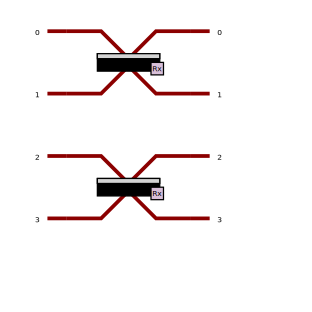

In [3]:
## Create the circuit

n = 2 #Nombre de modes spatiaux
m = 2 #Nombre de modes internes
k = 2 #Nombre de photon
circuit = pcvl.Circuit(n*m)
circuit.add((0,1), pcvl.BS())
circuit.add((2,3),pcvl.BS())

pcvl.pdisplay(circuit)

In [4]:
## Getting the c vector 
env_type = 1  # 1=Gaussian, 2=exponential
N = 100  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

sigma_wave = 0.5  # standard deviation of wave function
x = np.linspace(-16 * sigma_wave, 16 * sigma_wave, N)  # position values

shift_list=np.linspace(-8*sigma_wave,8*sigma_wave,100)
C2S=np.zeros(len(shift_list))
CL11 = np.zeros_like(C2S)
CL12 = np.zeros_like(C2S)
CL21 = np.zeros_like(C2S)
CL22 = np.zeros_like(C2S)
for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        waves[i] = Gaussian(x-x_shift[i], sigma_wave)

    new_base,coeffsS=Schmidt(waves,x)
    new_base,coeffsL = Lowdin(waves,x)
    C2S[k]=coeffsS[1,1]
    CL11[k] = coeffsL[0,0]
    CL12[k] = coeffsL[0,1]
    CL21[k] = coeffsL[1,0]
    CL22[k] = coeffsL[1,1]


In [5]:
print(C2S[99])

0.9999999437324113


In [6]:
## Create the inputs and simulation for Schmidt
ProbS = []
for coef in C2S:
    InputsBS = create_inputs(2,2,2,[1,0],[np.sqrt(1-coef ** 2),coef])

    
    #Get backend and simulation
    backend = pcvl.BackendFactory.get_backend("Naive")

    simulator = backend(circuit)
    Sol = simulator.allstateprob_iterator(InputsBS)

    ProbS.append(calculate_proba(n,m,[1,1],Sol))
    

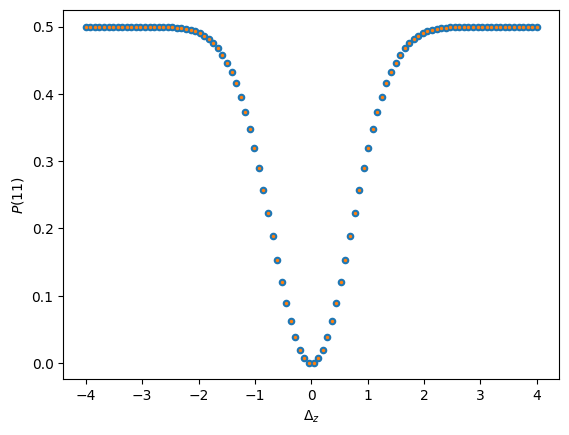

In [7]:
## Plot the results for schmidt
plt.figure()
plt.scatter(shift_list,C2S**2/2,20,label = 'Analytic')
plt.scatter(shift_list,ProbS,2,label = 'Simulation')
plt.xlabel(r'$\Delta_z$')
plt.ylabel(r'$P(11)$')
plt.show()


In [8]:
## Create the inputs and simulation for Lowdin
ProbL = []
for i in range(len(CL11)):
    InputsBS = create_inputs(2,2,2,[CL11[i],CL12[i]],[CL21[i],CL22[i]])

    
    #Get backend and simulation
    backend = pcvl.BackendFactory.get_backend("Naive")

    simulator = backend(circuit)
    Sol = simulator.allstateprob_iterator(InputsBS)

    ProbL.append(calculate_proba(n,m,[1,1],Sol))
    

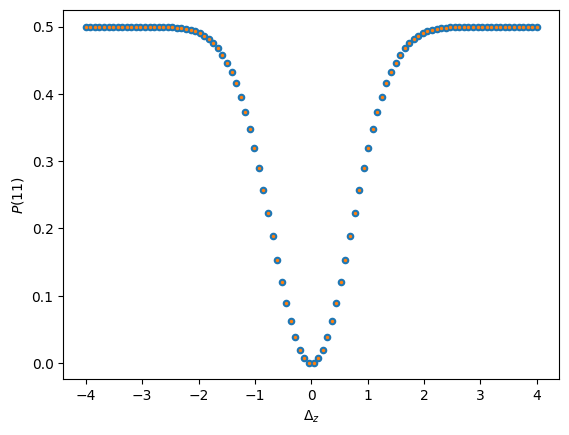

In [9]:
## Plot the results for Lowdin
plt.figure()
plt.scatter(shift_list,(CL11*CL22-CL12*CL21)**2/2,20,label = 'Analytic')
plt.scatter(shift_list,ProbL,2,label = 'Simulation')
plt.xlabel(r'$\Delta_z$')
plt.ylabel(r'$P(11)$')
plt.show()


In [10]:
import scipy as sc

#Lorentzian amplitude function :
## Analytique dip

N=2000
env_type = 2 # 1 = Gaussian, 2 = exponential (envelope in space)


if env_type == 1 :
    #Gaussian Parameters
    dz = 1e-8 #standard deviation in z
    lam = 500*1e-9 #wave length
    k0 = 2*np.pi/lam #mean k vector
    dk=1/(2*dz) #standard deviation in k 
    z = np.linspace(-13*dz, 13*dz,N)
    k = np.linspace(k0-13*dk, k0+13*dk, N)
    z0 = np.linspace(-8*dz, 8*dz, 100) # z0 : length of shift between photons
if env_type == 2 :
    #Lorentizian Parameters
    gamma = 0.5 #decaying factor in z
    lam = 500*1e-9 #wave length
    k0 = 2*np.pi/lam #mean k vector
    z = np.linspace(-16/gamma,16/gamma, N)
    k = np.linspace(k0-8*gamma,k0+8*gamma,N)
    z0 = np.linspace(-8/gamma, 8/gamma, 2000) # z0 : length of shift between photons


# Beam splitter transfer matrix
BS=1/np.sqrt(2) * np.array([[1,-1],[1,1]])
A = BS[0,0]; B = BS[0,1]; C = BS[1,0]; D = BS[1,1]



dip = np.zeros(len(z0))
for i in range(len(z0)):
    if env_type == 1 :
        env1 = Gaussian(z,dz)
        env2 = Gaussian(z,dz)
        env1_k = Gaussian(k,dk)
        env2_k = np.exp(1j*k*z0[i])*env1_k
    if env_type == 2 :
        env1 = Exponential(z,gamma)
        env2 = Exponential(z,gamma)
        env1_k = Lrz(gamma,k0,k)
        env2_k = np.exp(1j*k*z0[i])*env1_k
        
    overlap = abs(sc.integrate.simps(env1_k*np.conj(env2_k),k))**2
    Pr11 = abs(A)**2*abs(D)**2 + abs(B)**2*abs(C)**2 + 2*np.real(np.conj(A)*np.conj(D)*B*C)*overlap 
    dip[i] = Pr11
    
plt.figure()
plt.plot(z0,dip)
plt.xlabel(r"$z_0$")
plt.ylabel(r"$P(|11\rangle)$")
plt.title("HOM dip")


TypeError: Lrz() takes 2 positional arguments but 3 were given

In [ ]:
plt.figure()
plt.scatter(x,dip,20, label = 'Analytic')
plt.scatter(x,ProbS,2,label = 'Simulation')
plt.xlabel(r"$z_0$")
plt.ylabel(r"$P(|11\rangle)$")
plt.legend()
plt.title("HOM dip")

Test exponentielle

In [11]:
env_type = 2  # 1=Gaussian, 2=exponential
N = 501  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

gamma=0.5
sigma_wave = 2  # standard deviation of wave function
#x = np.linspace(-16 * sigma_wave, 16 * sigma_wave, N)  # position values
x = np.linspace(-16 / gamma, 16 /gamma, N)
#shift_list=np.linspace(-8*sigma_wave,8*sigma_wave,500)
shift_list=np.linspace(-8/gamma,8/gamma,N)

C2S = np.zeros(len(shift_list))
CL11 = np.zeros_like(C2S)
CL12 = np.zeros_like(C2S)
CL21 = np.zeros_like(C2S)
CL22 = np.zeros_like(C2S)
for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        #waves[i] = Gaussian(x-x_shift[i], sigma_wave)
        waves[i] = Exponential(x-x_shift[i], gamma)

    new_base,coeffsL=Lowdin(waves,x)

    CL11[k] = coeffsL[0,0]
    CL12[k] = coeffsL[0,1]
    CL21[k] = coeffsL[1,0]
    CL22[k] = coeffsL[1,1]

    

In [12]:
## Create the inputs and simulation for Lowdin
ProbL = []
for i in range(len(CL11)):
    InputsBS = create_inputs(2,2,2,[CL11[i],CL12[i]],[CL21[i],CL22[i]])

    
    #Get backend and simulation
    backend = pcvl.BackendFactory.get_backend("Naive")

    simulator = backend(circuit)
    Sol = simulator.allstateprob_iterator(InputsBS)

    ProbL.append(calculate_proba(n,m,[1,1],Sol))

In [13]:
#Comparison with analytical HOM dip

#lam = 0.5*sigma_wave #wave length
lam = 0.5/gamma
k0 = 2*np.pi/lam
#dk=1/(2*sigma_wave) #standard deviation in k 
#k = np.linspace(k0-13*dk, k0+13*dk, N)
k = np.linspace(k0-25*gamma,k0+25*gamma,N)
dip = np.zeros(len(shift_list))

# Beam splitter transfer matrix
BS=1/np.sqrt(2) * np.array([[1,-1],[1,1]])
A = BS[0,0]; B = BS[0,1]; C = BS[1,0]; D = BS[1,1]

for i in range(len(shift_list)):  
    if env_type==1:
        env1 = Gaussian(x,sigma_wave)
        env2 = Gaussian(x-shift_list[i],sigma_wave)
        env1_k = Gaussian(k-k0,dk)
        env2_k = np.exp(1j*k*shift_list[i])*env1_k
    if env_type==2:
        env1 = Exponential(x,gamma)
        env2 = Exponential(x-shift_list[i],gamma)
        env1_k = Lrz(k-k0,gamma)
        env2_k = np.exp(1j*k*shift_list[i])*env1_k
    overlap = abs(sc.integrate.simps(env1_k*np.conj(env2_k),k))**2
    Pr11 = abs(A)**2*abs(D)**2 + abs(B)**2*abs(C)**2 + 2*np.real(np.conj(A)*np.conj(D)*B*C)*overlap 
    dip[i] = Pr11
    

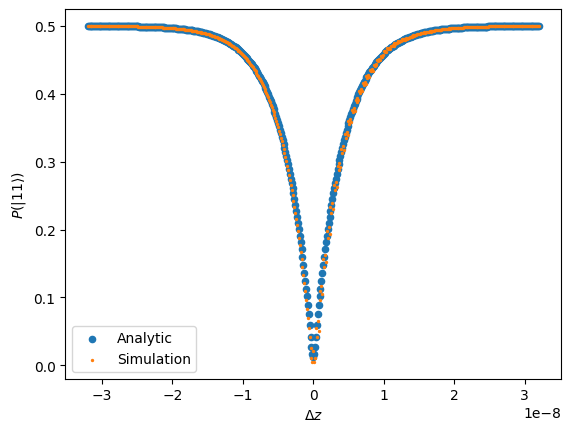

In [18]:
plt.figure()
plt.scatter(x/1e9,dip,20, label = 'Analytic')
plt.scatter(x/1e9,ProbL,2,label = 'Simulation')
plt.xlabel(r"$\Delta z$")
plt.ylabel(r"$P(|11\rangle)$")
plt.legend()


In [ ]:

print(ProbS)